# Прогнозирование количества заказов такси

#### Тема проекта:
- Прогнозирование количества заказов такси в период пиковой нагрузки

#### Цель:
- Построить модель, прогнозирующую количество заказов такси

#### Поставленные задачи:
- Подготовить данные для обучения;
- Проанализировать сезонность;
- Выделить признаки из временных данных;
- Обучить несколько моделей и сравнить результат;
- На тестовой выборке получить значение RMSE не выше 48.

#### Краткий план работы:
- [Шаг 1. Подготовка данных](#Шаг-1.-Подготовка-данных)
- [Шаг 2. Анализ сезонности](#Шаг-2.-Анализ-сезонности)
- [Шаг 3. Обучение моделей](#Шаг-3.-Обучение-моделей)
  - [3.1. Константная модель](#3.1.-Константная-модель)
  - [3.2. Линейная регрессия (LinearRegression)](#3.2.-Линейная-регрессия-(LinearRegression))
  - [3.3. Стохастический градиентный спуск (SGDRegressor)](#3.3.-Стохастический-градиентный-спуск-(SGDRegressor))
  - [3.4. Градиентный бустинг (LightGBMRegressor)](#3.4.-Градиентный-бустинг-(LightGBMRegressor))
- [Шаг 4. Тестирование](#Шаг-4.-Тестирование)


#### Вывод:
- Изучены и предобработаны предоставленные данные;
- Обнаружены сезонные закономерности;
- На тестовой выборке удалось достигнуть значения RMSE не выше 48.

**Статус проекта**: проект завершён.  

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *statsmodels*, *sklearn*, *lightgbm*

**Источник данных**: [курс Data Science от Яндекс.Практикум](https://praktikum.yandex.ru/profile/data-scientist/)

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функция для дальнейшей работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

## Шаг 1. Подготовка данных

Выгрузим исходные данные, выведем первые строки и рассмотрим общую информацию.    
Поскольку данные содержат индекс со временем, дополнительно проверим, нет ли задублированных дат.

In [2]:
# выгрузка файла
taxi = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=0)
# упорядочивание индекса
taxi.sort_index(inplace=True)

print('Количество задублированных дат:', len(taxi.index[taxi.index.duplicated()]))
print()
# вывод общей информации
print(taxi.info())

# вывод первых строк
taxi.head()

Количество задублированных дат: 0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


- Исходные данные содержат **26496 наблюдений**.
- **Время** наблюдений с 1 марта (время 00:00:00) по 31 августа 2018 года (время 23:50:00).
- В исходных данных отсутствуют пропуски.
- В датах отсутствуют дубликаты.

Сделаем **ресемплинг** по **одному часу**:

In [3]:
# ресемплинг по одному часу
taxi = taxi.resample('1H').sum()

# вывод общей информации
print(taxi.info())

taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


- Количество наблюдений сократилось с **26496** до **4416 строк**.

## Шаг 1. Вывод
    
- **Время** наблюдений с 1 марта (время 00:00:00) по 31 августа 2018 года (время 23:50:00).    
- В результате ресемплинга до 1 часа количество наблюдений **сократилось с 26496 до 4416 строк**.
- В исходных данных **отсутствуют пропуски**.
- В датах **отсутствуют дубликаты**.

## Шаг 2. Анализ сезонности

Сначала посмотрим, как будет выглядить график с почасовыми наблюдениями:

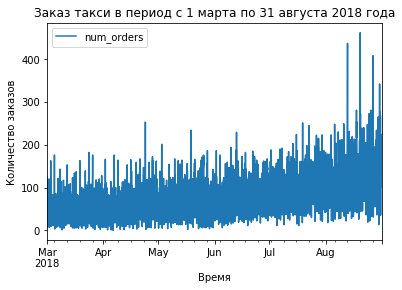

In [4]:
# график почасовых данных
taxi.plot()
plt.title('Заказ такси в период с 1 марта по 31 августа 2018 года')
plt.xlabel('Время'); plt.ylabel('Количество заказов')
plt.show()

Угадывается восходящий тренд, но из текущего изображения это не очевидно. Для удобства сделаем **ресемплинг по дням**:

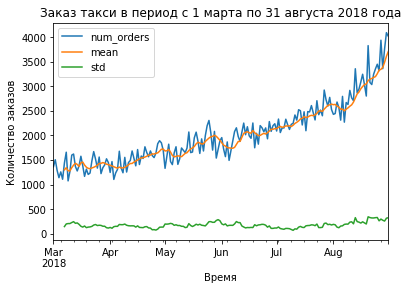

In [5]:
# ресепмлинг данных по дням
taxi_resample = taxi.resample('D').sum()
taxi_resample['mean'] = taxi_resample['num_orders'].rolling(7).mean()
taxi_resample['std'] = taxi_resample['num_orders'].rolling(7).std()

taxi_resample.plot()
plt.title('Заказ такси в период с 1 марта по 31 августа 2018 года')
plt.xlabel('Время'); plt.ylabel('Количество заказов')
plt.show()

- Меняется **среднее значение** - заметен восходящий тренд, значит, распределение зависит от времени.

Дополнительно можно декомпозировать данные на **тренд**, **сезонность** и **остатки**.

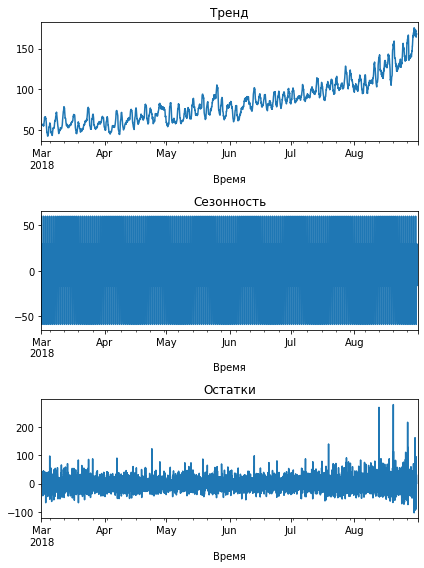

In [6]:
# декомпозируем taxi
taxi_decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))

plt.subplot(311)
taxi_decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд'); plt.xlabel('Время')

plt.subplot(312)
taxi_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность'); plt.xlabel('Время')

plt.subplot(313)
taxi_decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки'); plt.xlabel('Время')

plt.tight_layout()
plt.show()

- С течением времени количество заказов постепенно **увеличивается**.
- Поскольку срез дан за **неполный год**, сложно сказать, наблюдается ли рост продаж или это всего лишь сезонные колебания. Например, осенью традиционно растёт число продаж, потому что людям холодно добираться на общественном транспорте.

Изучим сезонность по **дням недели**, чтобы определить, более популярные и менее популярные дни:

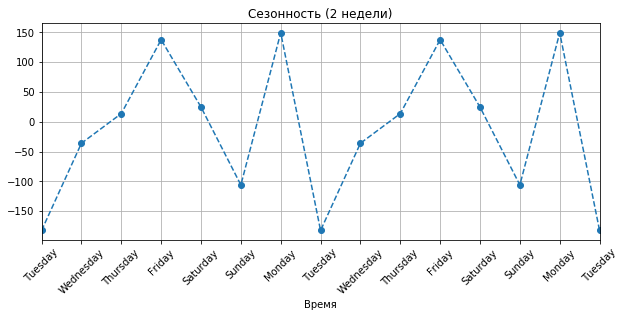

In [7]:
# ресепмлинг данных по дням
taxi_day = taxi.resample('D').sum()
taxi_day_decomposed = seasonal_decompose(taxi_day)

# срез 2 недели
taxi_day_decomposed.seasonal['2018-05-01' : '2018-05-15'].plot(figsize=(10, 4), linestyle='--', marker='o')
plt.title('Сезонность (2 недели)'); plt.xlabel('Время')

# использование дней недели вместо лейблов
tick_val = pd.date_range(start='2018-05-01', periods=15)
tick_lab = [i.day_name() for i in pd.date_range(start='2018-05-01', periods=15)]
plt.xticks(tick_val, tick_lab, rotation=45)

plt.grid()
plt.show()

- Наблюдается сезонность в зависимости от **дня недели**.
- **Наиболее популярные** дни для заказа такси - пятница и понедельник, **наименее популярные** - вторник и воскресенье.

Изучим сезонность по **времени суток**, чтобы определить более популярные и менее часы:

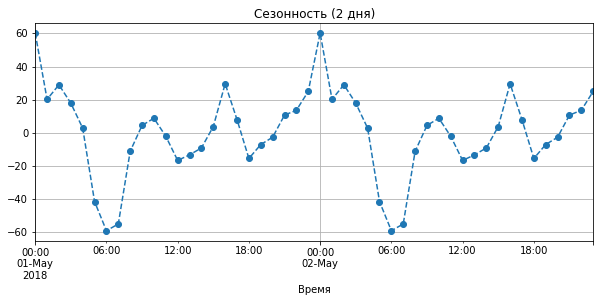

In [8]:
# срез 2 дня
taxi_decomposed.seasonal['2018-05-01': '2018-05-02'].plot(figsize=(10, 4), linestyle='--', marker='o')
plt.title('Сезонность (2 дня)'); plt.xlabel('Время')
plt.grid()
plt.show()

- Присутствует **внутрисуточная** сезонность.
- Начиная с 6 ч утра, количество заказов растёт (люди начинают выходить на работу). Далее количество заказов увеличивается в обеденное время после 12 ч, в конце рабочего дня после 18 ч и достигает пика в полночь, после чего начинает снижаться.

## Шаг 2. Вывод
    
- **Тренд**
 - С течением времени количество заказов постепенно **увеличивается**. Но поскольку срез дан за **неполный год**, сложно сказать, наблюдается ли рост продаж или это всего лишь сезонные колебания.
    
- **Сезонность**
 - **Внутрисуточная** - присутствует. Начиная с 6 ч утра, количество заказов растёт (люди начинают выходить на работу). Далее количество заказов увеличивается в обеденное время после 12 ч, в конце рабочего дня после 18 ч и достигает пика в полночь, после чего начинает снижаться.
 - **Дневная** - присутствует. **Наиболее популярные** дни для заказа такси - пятница и понедельник, **наименее популярные** - вторник и воскресенье.
 - **Месячная** - нельзя сделать однозначные выводы, т. к. представлены данные за один неполный год.

## Шаг 3. Обучение моделей

Рассмотрим обучение следующих моделей:
- [3.1. Константная модель](#3.1.-Константная-модель)
- [3.2. Линейная регрессия (LinearRegression)](#3.2.-Линейная-регрессия-(LinearRegression))
- [3.3. Стохастический градиентный спуск (SGDRegressor)](#3.3.-Стохастический-градиентный-спуск-(SGDRegressor))
- [3.4. Градиентный бустинг (LightGBMRegressor)](#3.4.-Градиентный-бустинг-(LightGBMRegressor))

В качестве проверочной метрики будем использовать **RMSE (корень из MSE, средней квадратической ошибки)**.

Для дальнейшего обучения необходимо создать **признаки** и отдельно выделить **целевой признак**.  
Напишем функцию и создадим следующие признаки:  

- **1. Календарные признаки**: день недели, час.
- **2. Отстающие значения**: создадим параметр `max_lag`, который будет регулировать шаг сдвига.
- **3. Скользящее среднее**: размер окна `rolling_mean_size` для скользяшего среднего.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    
    """Функция создаёт признаки на основе имеющихся временных данных:
    - data - наименование датафрейма;
    - max_lag - количество единичных шагов сдвига;
    - rolling_mean_size - размер диапазона для скользящего среднего."""
    
    # убирает лишние ряды
    data = data[['num_orders']]
    
    # календарные признаки
    data['dayofweek'] = data.index.dayofweek # есть сезонность дней недели
    data['hour'] = data.index.hour # есть внутрисуточная сезонность
    
    # отстающие признаки
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # скользящее среднее   
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Напишем функцию, которая будет **удалять** ряды с образовавшимися **пропусками** и разделять данные на **обучающую и тестовую** выборки:

In [10]:
def dropna_split(data, target_col):
    
    """Функция удаляет пропуски и делит выборку на обучающую и тестовую:
    - data - наименование датафрейма;
    - target_col - название колонки с целевой переменной (в кавычках)."""
    
    # удаление рядов с пропусками
    data.dropna(inplace=True)
    
    # выделение признаков и целевого признака
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # разделение выборки на тестовую и обучающую
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1) 
    
    return X_train, X_test, y_train, y_test

Создадим несколько **датафреймов** с разным количеством **признаков**:
- В качестве `max_lag` выберем значения 6 и 12 (мониторинг измерений за 6 и 12 часов).
- В качестве `rolling_mean_size` (скользящего среднего) выберем 12 и 24 часа .

In [11]:
SEED = 888

# max_lag=6, rolling_mean_size=12
taxi_6_12 = make_features(taxi, 6, 12)
X_train_6_12, X_test_6_12, y_train_6_12, y_test_6_12 = dropna_split(taxi_6_12, 'num_orders')

# max_lag=12, rolling_mean_size=12
taxi_12_12 = make_features(taxi, 12, 12)
X_train_12_12, X_test_12_12, y_train_12_12, y_test_12_12 = dropna_split(taxi_12_12, 'num_orders')

# max_lag=6, rolling_mean_size=24
taxi_6_24 = make_features(taxi, 6, 24)
X_train_6_24, X_test_6_24, y_train_6_24, y_test_6_24 = dropna_split(taxi_6_24, 'num_orders')

# max_lag=12, rolling_mean_size=24
taxi_12_24 = make_features(taxi, 12, 24)
X_train_12_24, X_test_12_24, y_train_12_24, y_test_12_24 = dropna_split(taxi_12_24, 'num_orders')

# список с выборками
df_dict = {'max_lag=6, rolling_mean_size=12': [X_train_6_12, y_train_6_12],
           'max_lag=12, rolling_mean_size=12': [X_train_12_12, y_train_12_12],
           'max_lag=6, rolling_mean_size=24': [X_train_6_24, y_train_6_24],
           'max_lag=12, rolling_mean_size=24': [X_train_12_24, y_train_12_24]}

### 3.1. Константная модель

В качестве константы используем значение **медианы** и рассчитаем **RMSE**:

In [12]:
# выделение признаков и целевого признака
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']
    
# разделение выборки на тестовую и обучающую БЕЗ перемешивания
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1) 

# создание Series со значениями медианы
y_pred_median = pd.Series(y_train.median(), index=y_test.index)

# расчёт метрики RMSE
rmse_median = mean_squared_error(y_test, y_pred_median) ** (1/2)
print('RMSE (константа медиана):', rmse_median)

RMSE (константа медиана): 87.15277582981295


- Значение **RMSE** явно **больше** необходимого значения **48**.
- Если **RMSE** модели будет **больше 87.2**, это говорит о том, что результаты предсказания **хуже**, чем предсказание константой.

Перейдём к обучению моделей с различными гиперпараметрами.

### 3.2. Линейная регрессия (LinearRegression)

In [13]:
%%time
# подбор гиперпараметров
lr_cv = GridSearchCV(estimator=LinearRegression(),
                     param_grid={'fit_intercept':[True, False]},
                     cv=3, scoring='neg_mean_squared_error')

for df_name, df_value in df_dict.items():
    print(f'Датафрейм: {df_name}')
    lr_cv.fit(df_value[0], df_value[1])
    lr_cv_params = lr_cv.best_params_
    lr_cv_score = np.sqrt(np.abs(lr_cv.best_score_))
    print("Лучшая комбинация: {}".format(lr_cv_params))
    print("Лучшее значение RMSE: {}".format(lr_cv_score))
    print()

Датафрейм: max_lag=6, rolling_mean_size=12
Лучшая комбинация: {'fit_intercept': False}
Лучшее значение RMSE: 31.562570112722234

Датафрейм: max_lag=12, rolling_mean_size=12
Лучшая комбинация: {'fit_intercept': False}
Лучшее значение RMSE: 31.257253160674047

Датафрейм: max_lag=6, rolling_mean_size=24
Лучшая комбинация: {'fit_intercept': False}
Лучшее значение RMSE: 31.07372577332696

Датафрейм: max_lag=12, rolling_mean_size=24
Лучшая комбинация: {'fit_intercept': False}
Лучшее значение RMSE: 30.809881356626025

Wall time: 93.2 ms


- На всех датасетах значения RMSE достаточно похоже.
- В данном случае наилучший результат получен для датафрейма *max_lag=12, rolling_mean_size=24*.
- Во всех случаях рекомендуется не рассчитывать *intercept*.

### 3.3. Стохастический градиентный спуск (SGDRegressor)

In [14]:
%%time
# подбор гиперпараметров
sgd_cv = RandomizedSearchCV(estimator=SGDRegressor(random_state=SEED),
                            param_distributions={'penalty': ['l1', 'l2', 'elasticnet'],
                                                 'alpha': [0.0001, 0.001, 0.005], 
                                                 'loss': ['huber', 'squared_loss'],
                                                 'max_iter': [10, 100, 500, 1000]},
                            cv=3, scoring='neg_mean_squared_error', random_state=SEED)

for df_name, df_value in df_dict.items():
    print(f'Датафрейм: {df_name}')
    sgd_cv.fit(df_value[0], df_value[1])
    sgd_cv_params = sgd_cv.best_params_
    sgd_cv_score = np.sqrt(np.abs(sgd_cv.best_score_))
    print("Лучшая комбинация: {}".format(sgd_cv_params))
    print("Лучшее значение RMSE: {}".format(sgd_cv_score))
    print()

Датафрейм: max_lag=6, rolling_mean_size=12
Лучшая комбинация: {'penalty': 'elasticnet', 'max_iter': 10, 'loss': 'huber', 'alpha': 0.005}
Лучшее значение RMSE: 32.40399072853353

Датафрейм: max_lag=12, rolling_mean_size=12
Лучшая комбинация: {'penalty': 'elasticnet', 'max_iter': 10, 'loss': 'huber', 'alpha': 0.005}
Лучшее значение RMSE: 32.32327436064245

Датафрейм: max_lag=6, rolling_mean_size=24
Лучшая комбинация: {'penalty': 'elasticnet', 'max_iter': 10, 'loss': 'huber', 'alpha': 0.005}
Лучшее значение RMSE: 31.298895103054793

Датафрейм: max_lag=12, rolling_mean_size=24
Лучшая комбинация: {'penalty': 'l2', 'max_iter': 500, 'loss': 'huber', 'alpha': 0.0001}
Лучшее значение RMSE: 31.253309122746476

Wall time: 1.9 s


- На всех датасетах значения RMSE достаточно похоже.
- В случае со стохастическим градиентным спуском наилучшие результаты также получились при *max_lag=12, rolling_mean_size=24*.
- Результат получился немного хуже, чем для линейной регрессии.
- Рекомендуемая комбинация гиперпараметров для этого датафрейма: *'penalty': 'l2', 'max_iter': 500, 'loss': 'huber', 'alpha': 0.0001*.

### 3.4. Градиентный бустинг (LightGBMRegressor)

In [15]:
%%time
# подбор гиперпараметров
lgb_cv = RandomizedSearchCV(estimator=LGBMRegressor(random_state=SEED, silent=True),
                            param_distributions={'learning_rate': [0.01, 0.1, 0.5],
                                                 'n_estimators': np.arange(100, 701, 200),
                                                 'num_leaves':np.arange(30, 51, 10)},
                            cv=3, scoring='neg_mean_squared_error', random_state=SEED)

for df_name, df_value in df_dict.items():
    print(f'Датафрейм: {df_name}')
    lgb_cv.fit(df_value[0], df_value[1])
    lgb_cv_params = lgb_cv.best_params_
    lgb_cv_score = np.sqrt(np.abs(lgb_cv.best_score_))
    print("Лучшая комбинация: {}".format(lgb_cv_params))
    print("Лучшее значение RMSE: {}".format(lgb_cv_score))
    print()

Датафрейм: max_lag=6, rolling_mean_size=12
Лучшая комбинация: {'num_leaves': 40, 'n_estimators': 100, 'learning_rate': 0.1}
Лучшее значение RMSE: 26.365078908797056

Датафрейм: max_lag=12, rolling_mean_size=12
Лучшая комбинация: {'num_leaves': 40, 'n_estimators': 100, 'learning_rate': 0.1}
Лучшее значение RMSE: 25.465169564814293

Датафрейм: max_lag=6, rolling_mean_size=24
Лучшая комбинация: {'num_leaves': 50, 'n_estimators': 700, 'learning_rate': 0.01}
Лучшее значение RMSE: 26.29246176028586

Датафрейм: max_lag=12, rolling_mean_size=24
Лучшая комбинация: {'num_leaves': 50, 'n_estimators': 700, 'learning_rate': 0.01}
Лучшее значение RMSE: 25.161795993715828

Wall time: 1min


- На всех датасетах значения RMSE достаточно похоже.
- Лучший результат также продемонстрирован на *max_lag=12, rolling_mean_size=24*.
- Наилучшая комбинация гиперпараметров модели: *'num_leaves': 50, 'n_estimators': 700, 'learning_rate': 0.01*.
- Из всех рассматриваемых моделей градиентный бустинг продемонстрировал наилучший результат на всех датасетах.

## Шаг 3. Вывод
 
- Данные разделены на **обучающую** и **тестовую** выборки, размер **тестовой** выборки - 10%.
- Получено значение для константной модели с **медианой**, значение **RMSE 87.2**.
- Обучены **модели**: *линейная регрессия, стохастический градиентный спуск, градиентный бустинг LightGBM*:
 - В рамках одной модели на всех датасетах значения **RMSE** достаточно **похоже**.
 - Наилучший результат получен для датафрейма *max_lag=12, rolling_mean_size=24*.
 - Наменьшее значение **RMSE** получено при использовании градиентного бустинга.
 - Наилучшие комбинации гиперпараметров для моделей:
   - **Линейная регрессия (LinearRegression)**: *'fit_intercept': False*.
   - **Стохастический градиентный спуск (SGDRegressor)**: *'penalty': 'l2', 'max_iter': 500, 'loss': 'huber', 'alpha': 0.0001*.
   - **Градиентный бустинг (LightGBMRegressor)**: *'num_leaves': 50, 'n_estimators': 700, 'learning_rate': 0.01*.

## Шаг 4. Тестирование

Проверим модели с наилучшей комбинацией гиперпараметров на тестовой выборке *max_lag=12, rolling_mean_size=24*:

In [16]:
# линейная регрессия
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train_12_24, y_train_12_24)
lr_pred = lr.predict(X_test_12_24)
lr_rmse = np.sqrt(mean_squared_error(y_test_12_24, lr_pred))
print(f'Значение RMSE (линейная регрессия): {lr_rmse}')

# стохастический градиентный спуск
sgd = SGDRegressor(random_state=SEED, penalty='l2', max_iter=500, loss='huber', alpha=0.0001)
sgd.fit(X_train_12_24, y_train_12_24)
sgd_pred = sgd.predict(X_test_12_24)
sgd_rmse = np.sqrt(mean_squared_error(y_test_12_24, sgd_pred))
print(f'Значение RMSE (стохастический градиентный спуск): {sgd_rmse}')

# градиентный бустинг
lgb = LGBMRegressor(random_state=SEED, silent=True, learning_rate=0.01, n_estimators=700, num_leaves=50)
lgb.fit(X_train_12_24, y_train_12_24)
lgb_pred = lgb.predict(X_test_12_24)
lgb_rmse = np.sqrt(mean_squared_error(y_test_12_24, lgb_pred))
print(f'Значение RMSE (градиентный бустинг): {lgb_rmse}')

Значение RMSE (линейная регрессия): 50.174144454546905
Значение RMSE (стохастический градиентный спуск): 50.96438273113767
Значение RMSE (градиентный бустинг): 42.54274625803635


- Для всех моделей результат заметно **хуже**, чем при **обучении** модели.
- Наилучший результат по-прежнему у модели **градиентного бустинга** - **RMSE 42.5** (не превосходит 48).

Построим график со сравнением **реальных и предсказанных** значений по всем моделям, чтобы понимать, где предсказания отличаются от реальных значений сильнее всего:

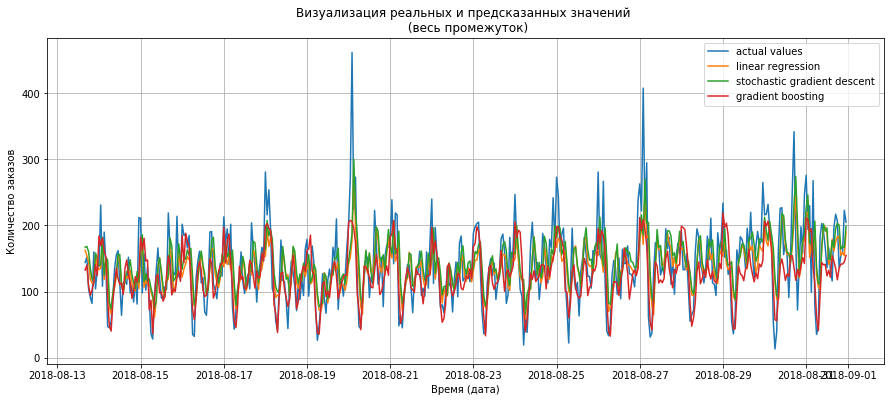

In [17]:
# значения на  всём промежутке
plt.figure(figsize=(15,6))
plt.plot(y_test_12_24, label='actual values')
for model_pred in [(lr_pred, 'linear regression'), (sgd_pred, 'stochastic gradient descent'), (lgb_pred, 'gradient boosting')]:
    plt.plot(pd.Series(model_pred[0], index=y_test_12_24.index), label=model_pred[1])

plt.title('Визуализация реальных и предсказанных значений \n (весь промежуток)')
plt.xlabel('Время (дата)'); plt.ylabel('Количество заказов')

plt.legend(); plt.grid(); plt.show()

График за **весь** промежуток получился не очень наглядным. Поэтому сократим промежуток до **нескольких дней**:

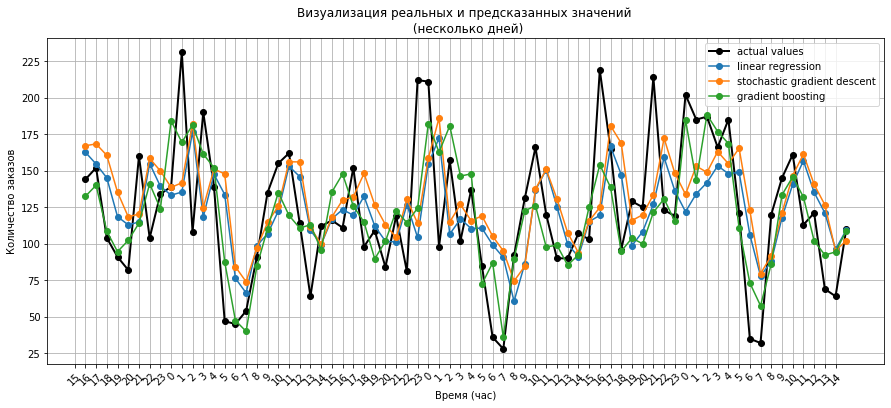

In [18]:
# значения для нескольких дней
plt.figure(figsize=(15,6))
plt.plot(y_test_12_24.head(72), marker='o', color='black', linewidth=2, label='actual values')
for model_pred in [(lr_pred, 'linear regression'), (sgd_pred, 'stochastic gradient descent'), (lgb_pred, 'gradient boosting')]:
    plt.plot(pd.Series(model_pred[0], index=y_test_12_24.index).head(72), marker='o', label=model_pred[1])

plt.title('Визуализация реальных и предсказанных значений \n (несколько дней)')
plt.xlabel('Время (час)'); plt.ylabel('Количество заказов')

# использование дней недели вместо лейблов
tick_val = pd.date_range(start='2018-08-13 15:00:00', periods=72, freq='H')
tick_lab = [i.hour for i in tick_val]
plt.xticks(tick_val, tick_lab, rotation=45)

plt.legend(); plt.grid(); plt.show()

- **Градиентный бустинг** лучше остальных моделей определяет **пики** роста и падения.
- **Линейная регрессия (ЛР)** и **стохастический градиентный спуск (СГС)** с бóльшим опозданием реагируют на **пики**.
- В целом **ЛР** и **СГС**  дают очень близкие предсказания.

## Шаг 4. Вывод
 
- Для всех моделей результат заметно **хуже**, чем при **обучении** модели.
- Наилучший результат по-прежнему у модели **градиентного бустинга** - **RMSE 42.5** (не превосходит 48).
- Чтобы понимать, где предсказания отличаются от реальных значений сильнее всего, мы построили график с **реальными** и **предсказанными** значениями моделей.
- Наглядным получился график со сравнением **по часам для нескольких дней**:
  - **Градиентный бустинг** лучше остальных моделей определяет **пики** роста и падения.
  - **Линейная регрессия (ЛР)** и **стохастический градиентный спуск (СГС)** с бóльшим опозданием реагируют на **пики**.
  - В целом **ЛР** и **СГС**  дают очень близкие предсказания.

# Итоговый вывод
    
## Шаг 1. Подготовка данных
- **Время** наблюдений с 1 марта (время 00:00:00) по 31 августа 2018 года (время 23:50:00).    
- В результате ресемплинга до 1 часа количество наблюдений **сократилось с 26496 до 4416 строк**.
- В исходных данных **отсутствуют пропуски**.
- В датах **отсутствуют дубликаты**.
    
    
## Шаг 2. Анализ сезонности
- **Тренд**
 - С течением времени количество заказов постепенно **увеличивается**. Но поскольку срез дан за **неполный год**, сложно сказать, наблюдается ли рост продаж или это всего лишь сезонные колебания.
    
- **Сезонность**
 - **Внутрисуточная** - присутствует. Начиная с 6 ч утра, количество заказов растёт (люди начинают выходить на работу). Далее количество заказов увеличивается в обеденное время после 12 ч, в конце рабочего дня после 18 ч и достигает пика в полночь, после чего начинает снижаться.
 - **Дневная** - присутствует. **Наиболее популярные** дни для заказа такси - пятница и понедельник, **наименее популярные** - вторник и воскресенье.
 - **Месячная** - нельзя сделать однозначные выводы, т. к. представлены данные за один неполный год.
    
    
## Шаг 3. Обучение моделей
- Данные разделены на **обучающую** и **тестовую** выборки, размер **тестовой** выборки - 10%.
- Получено значение для константной модели с **медианой**, значение **RMSE 87.2**.
- Обучены **модели**: *линейная регрессия, стохастический градиентный спуск, градиентный бустинг LightGBM*:
 - В рамках одной модели на всех датасетах значения **RMSE** достаточно **похоже**.
 - Наилучший результат получен для датафрейма *max_lag=12, rolling_mean_size=24*.
 - Наменьшее значение **RMSE** получено при использовании градиентного бустинга.
 - Наилучшие комбинации гиперпараметров для моделей:
   - **Линейная регрессия (LinearRegression)**: *'fit_intercept': False*.
   - **Стохастический градиентный спуск (SGDRegressor)**: *'penalty': 'l2', 'max_iter': 500, 'loss': 'huber', 'alpha': 0.0001*.
   - **Градиентный бустинг (LightGBMRegressor)**: *'num_leaves': 50, 'n_estimators': 700, 'learning_rate': 0.01*.
   

## Шаг 4. Тестирование
- Для всех моделей результат заметно **хуже**, чем при **обучении** модели.
- Наилучший результат по-прежнему у модели **градиентного бустинга** - **RMSE 42.8** (не превосходит 48).
- Чтобы понимать, где предсказания отличаются от реальных значений сильнее всего, мы построили график с **реальными** и **предсказанными** значениями моделей.
- Наглядным получился график со сравнением **по часам для нескольких дней**:
  - **Градиентный бустинг** лучше остальных моделей определяет **пики** роста и падения.
  - **Линейная регрессия (ЛР)** и **стохастический градиентный спуск (СГС)** с бóльшим опозданием реагируют на **пики**.
  - В целом **ЛР** и **СГС**  дают очень близкие предсказания.